In [ ]:
from google.colab import drive
from itertools import cycle
import cv2
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL.ImageOps
import seaborn as sns
import tensorflow as tf
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.utils import to_categorical
from PIL import Image
import random
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.utils import shuffle

In [ ]:
# import data.
drive.mount('/content/drive')
!unzip /content/drive/My\ Drive/letterDataset.zip

df = pd.read_csv("/content/A_Z Handwritten Data.csv")

In [ ]:
df.rename(columns={'0':'label'}, inplace=True)

df = shuffle(df)
X = df.drop('label',axis = 1)
y = df['label']

X.shape, y.shape

((372450, 784), (372450,))

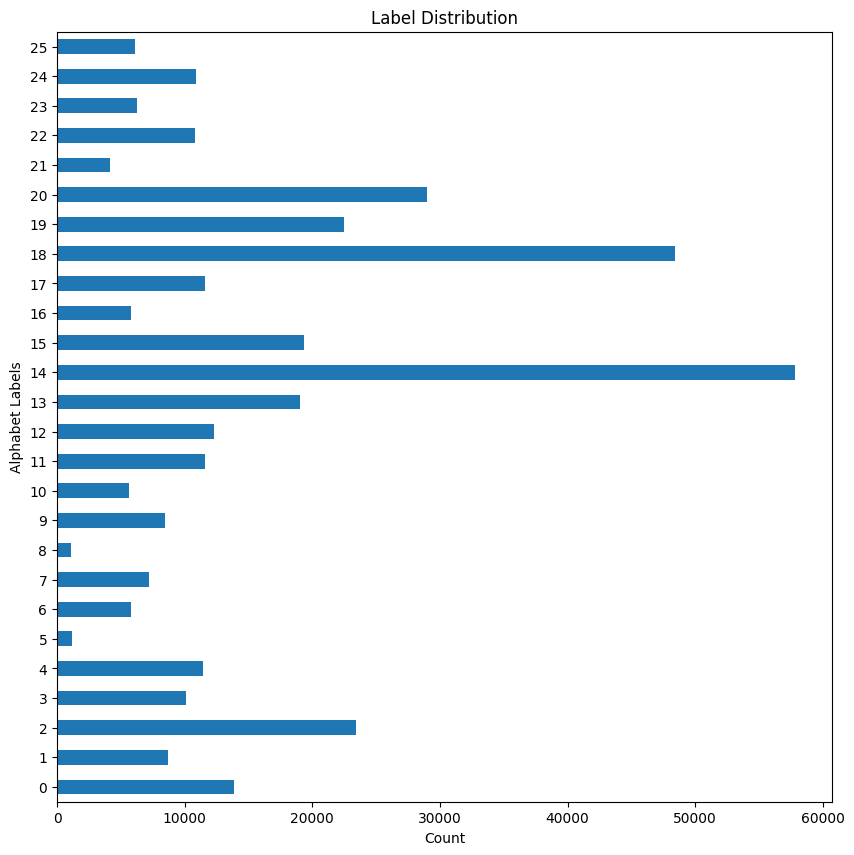

In [ ]:
label_size = df.groupby('label').size()
del df    # for RAM

label_size.plot.barh(figsize=(10, 10))
plt.xlabel("Count")
plt.ylabel("Alphabet Labels")
plt.title("Label Distribution")
plt.show()

In [ ]:
label_size.min(),label_size.max(), label_size.mean()

(1120, 57825, 14325.0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

In [ ]:
l =len(y.unique())
del X # for RAM
del y

In [ ]:
standard_scaler = MinMaxScaler()
standard_scaler.fit(X_train)

X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

In [ ]:
joblib.dump(standard_scaler, 'scaler.save') # to unscale later

['scaler.save']

In [ ]:
# prep for CNN
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(28, 28, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), input_shape=(28, 28, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(l, activation='softmax')) # l = 26

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 227,098 (887.10 KB)

 Trainable params: 227,098 (887.10 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=8, batch_size=256, verbose=1)

Epoch 1/8
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 392s 332ms/step - accuracy: 0.8313 - loss: 0.5927 - val_accuracy: 0.9757 - val_loss: 0.0849
Epoch 2/8
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 417s 311ms/step - accuracy: 0.9710 - loss: 0.1008 - val_accuracy: 0.9838 - val_loss: 0.0596
Epoch 3/8
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 395s 322ms/step - accuracy: 0.9782 - loss: 0.0763 - val_accuracy: 0.9842 - val_loss: 0.0556
Epoch 4/8
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 366s 308ms/step - accuracy: 0.9815 - loss: 0.0639 - val_accuracy: 0.9867 - val_loss: 0.0482
Epoch 5/8
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 381s 307ms/step - accuracy: 0.9835 - loss: 0.0558 - val_accuracy: 0.9886 - val_loss: 0.0403
Epoch 6/8
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 383s 308ms/step - accuracy: 0.9847 - loss: 0.0501 - val_accuracy: 0.9897 - val_loss: 0.0382
Epoch 7/8
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 348s 299ms/step - accuracy: 0.9866 - loss: 0.0434 - val_accuracy: 0.9906 - val_loss: 0.0356
Epoch 8/8
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 389s 305ms/step - accuracy: 

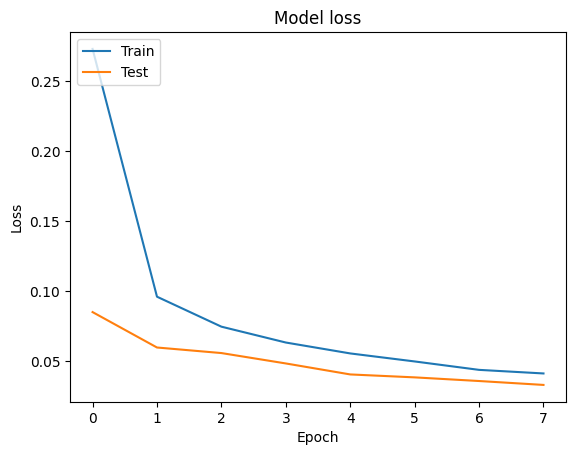

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

2328/2328 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step


In [ ]:
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Test\nAccuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Test
Accuracy: 0.9911934487850719
Precision: 0.9911967830609063
Recall: 0.9911934487850719
F1-Score: 0.9911756849886801


In [ ]:
y_pred_probs_train = model.predict(X_train)
y_pred_classes_train = np.argmax(y_pred_probs_train, axis=1)
y_true_classes_train = np.argmax(y_train, axis=1)

9312/9312 ━━━━━━━━━━━━━━━━━━━━ 146s 16ms/step


In [ ]:
accuracy1 = accuracy_score(y_true_classes_train, y_pred_classes_train)
precision1 = precision_score(y_true_classes_train, y_pred_classes_train, average='weighted')
recall1 = recall_score(y_true_classes_train, y_pred_classes_train, average='weighted')
f11 = f1_score(y_true_classes_train, y_pred_classes_train, average='weighted')

print(f"Train\nAccuracy: {accuracy1}")
print(f"Precision: {precision1}")
print(f"Recall: {recall1}")
print(f"F1-Score: {f11}")

Train
Accuracy: 0.9949422741307558
Precision: 0.9949420093040068
Recall: 0.9949422741307558
F1-Score: 0.994932321045161


2328/2328 ━━━━━━━━━━━━━━━━━━━━ 44s 19ms/step


<Axes: >

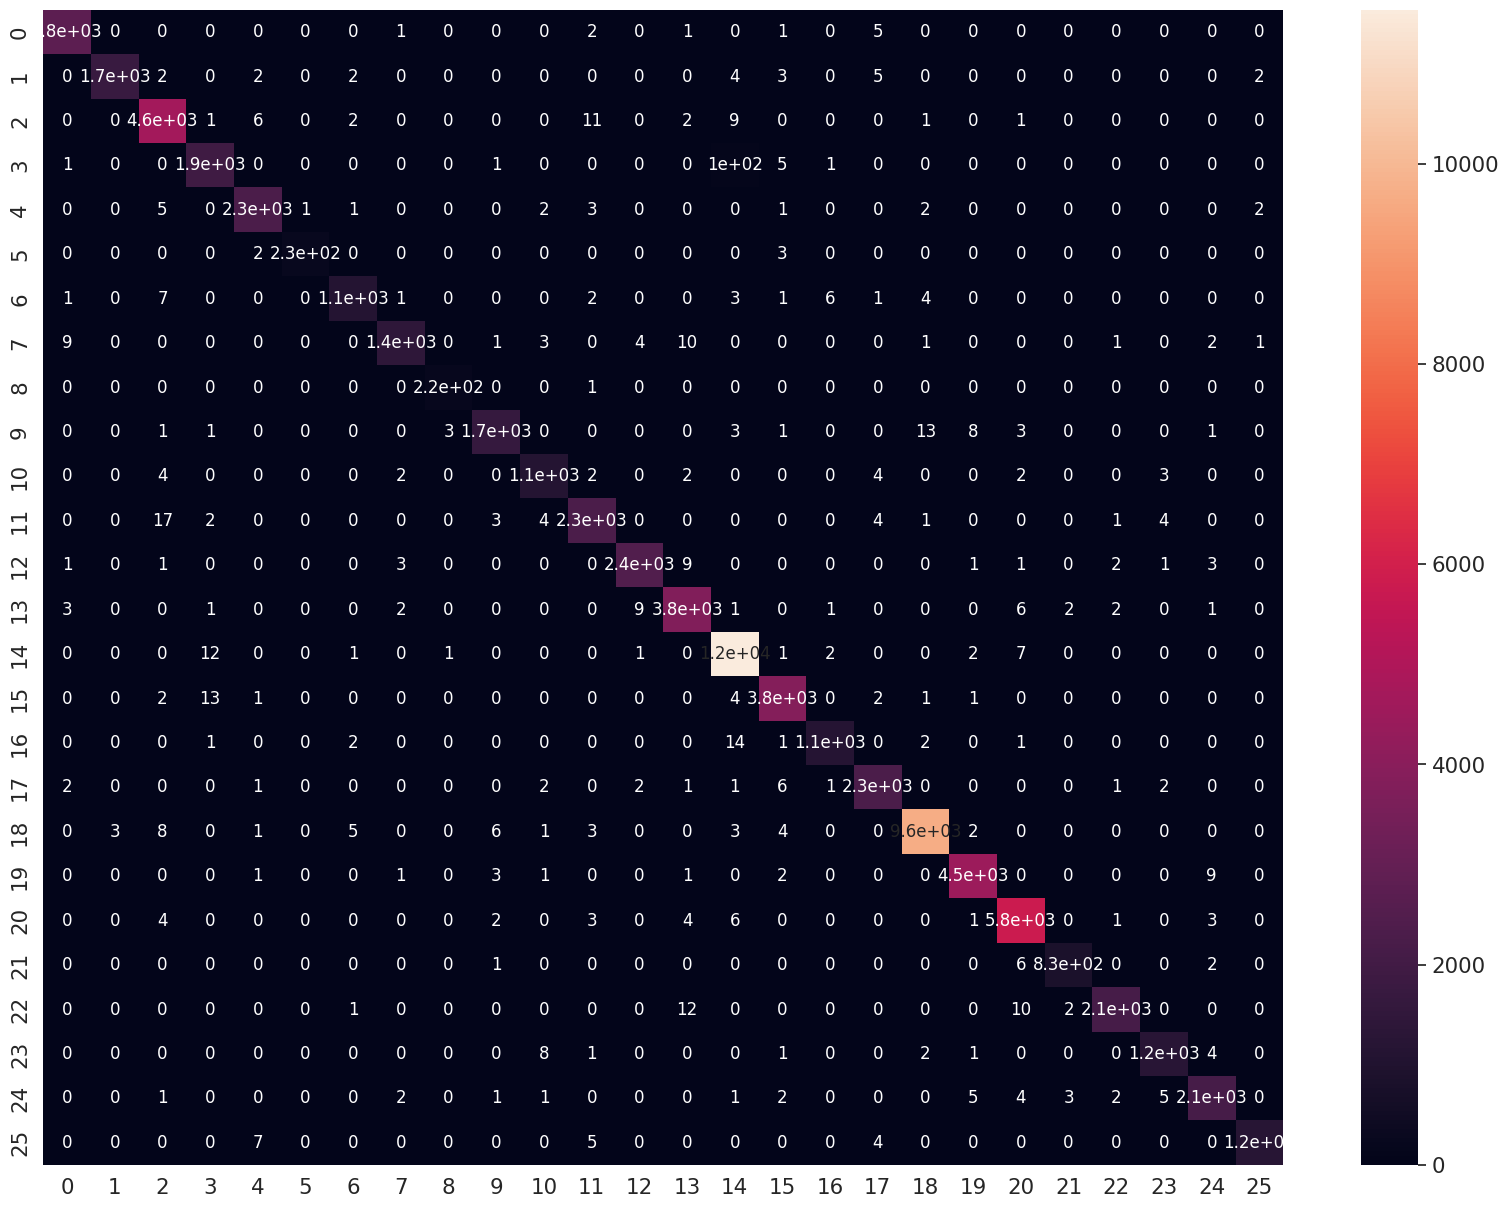

In [ ]:
cm=confusion_matrix(y_test.argmax(axis=1),model.predict(X_test).argmax(axis=1))
df_cm = pd.DataFrame(cm, range(26),
                  range(26))
plt.figure(figsize = (20,15))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12})

In [ ]:

misclassified_pairs = []
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i != j and cm[i, j] > 0:
            misclassified_pairs.append((i, j, cm[i, j]))

misclassified_pairs = sorted(misclassified_pairs, key=lambda x: x[2], reverse=True)

for i, (true_label, pred_label, count) in enumerate(misclassified_pairs[:10]):
    print(f"True Label: {chr(true_label + ord('A'))}, Predicted Label: {chr(pred_label + ord('A'))}, Count: {count}")

True Label: D, Predicted Label: O, Count: 102
True Label: L, Predicted Label: C, Count: 17
True Label: Q, Predicted Label: O, Count: 14
True Label: J, Predicted Label: S, Count: 13
True Label: P, Predicted Label: D, Count: 13
True Label: O, Predicted Label: D, Count: 12
True Label: W, Predicted Label: N, Count: 12
True Label: C, Predicted Label: L, Count: 11
True Label: H, Predicted Label: N, Count: 10
True Label: W, Predicted Label: U, Count: 10


Index: 7822
True Label: Y, Predicted Label: X


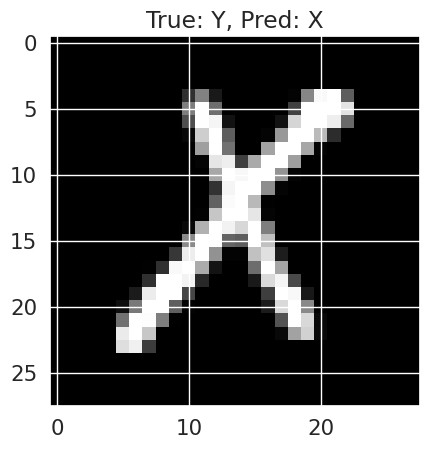

Index: 69329
True Label: L, Predicted Label: C


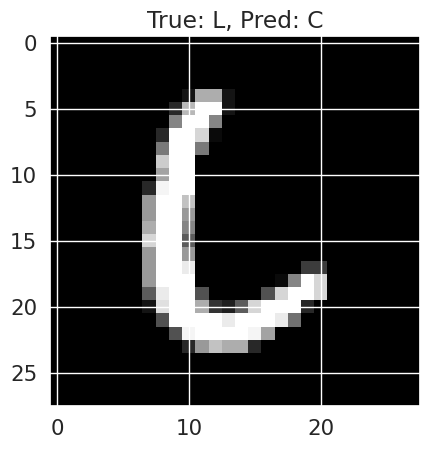

Index: 48188
True Label: P, Predicted Label: E


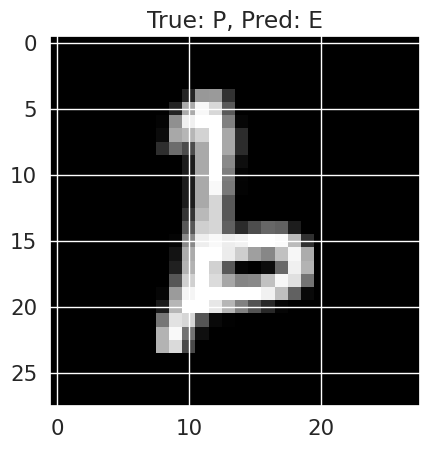

Index: 27515
True Label: L, Predicted Label: C


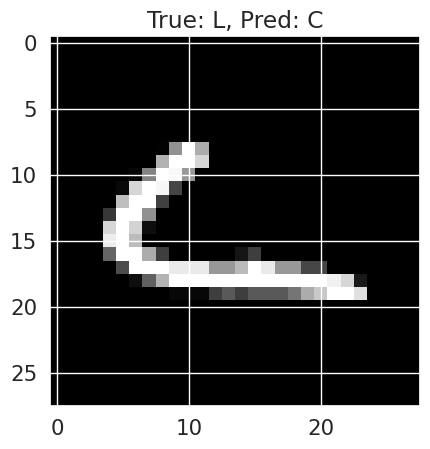

Index: 39081
True Label: Z, Predicted Label: L


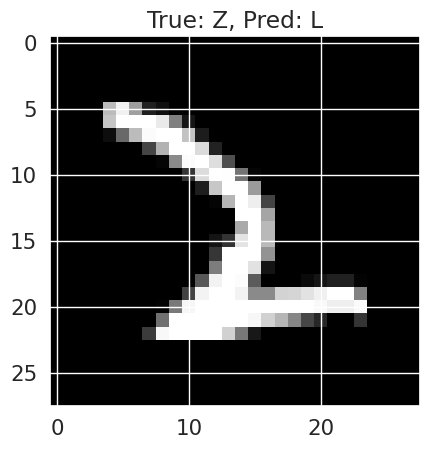

In [ ]:
misclassified_indices = np.where((y_true_classes != y_pred_classes))[0]
random.shuffle(misclassified_indices)

# print a couple of misclassified examples
for idx in misclassified_indices[:5]:  # Limit to 5 examples
    print(f"Index: {idx}")
    print(f"True Label: {chr(y_true_classes[idx] + ord('A'))}, Predicted Label: {chr(y_pred_classes[idx] + ord('A'))}")
    plt.imshow(X_test[idx], cmap='gray')
    plt.title(f"True: {chr(y_true_classes[idx] + ord('A'))}, Pred: {chr(y_pred_classes[idx] + ord('A'))}")
    plt.show()

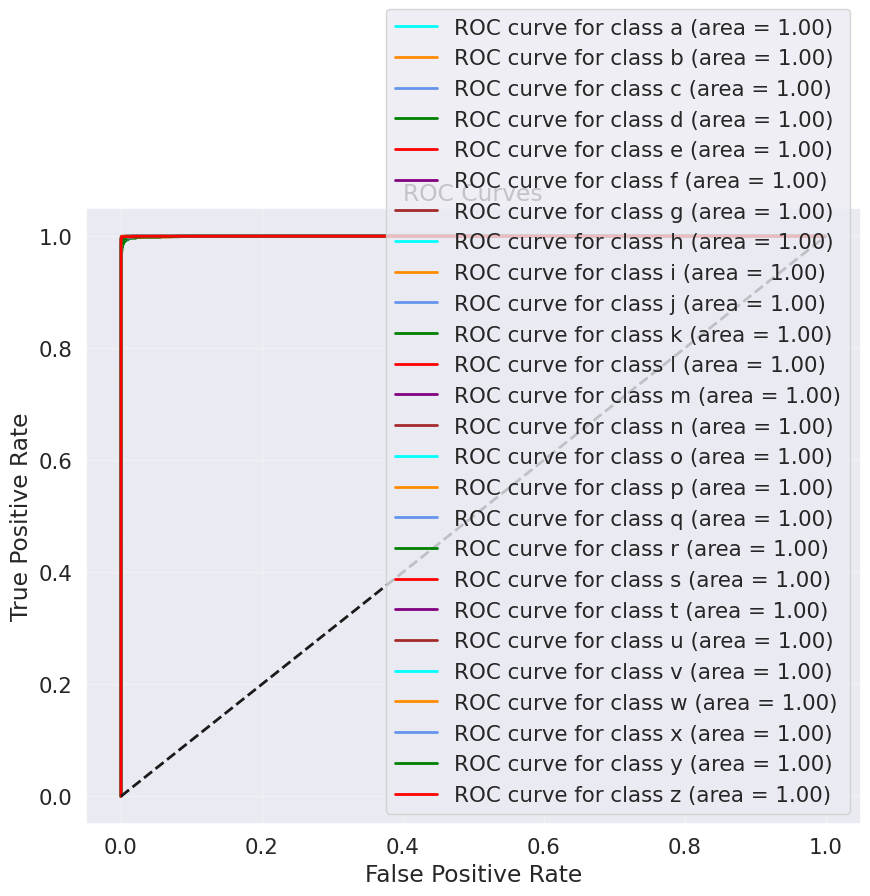

In [ ]:
y_score = y_pred_probs

n_classes = y_test.shape[1]
y_test_bin = y_test

fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
colors = cycle(["aqua", "darkorange", "cornflowerblue", "green", "red", "purple", "brown"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label=f"ROC curve for class {chr(i + ord('a'))} (area = {roc_auc[i]:.2f})",
    )

# diagonal line (random chance)
plt.plot([0, 1], [0, 1], "k--", lw=2)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
model.save("/content/hw_final.keras")

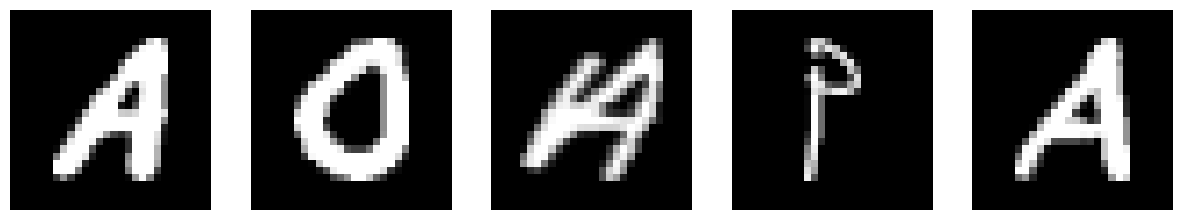

(28, 28, 1)

In [ ]:
num_examples = 5
fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))

for i in range(num_examples):
    axes[i].imshow(X_train[i].reshape(28, 28), cmap='gray')
    axes[i].axis('off')

plt.show()

X_train[i].shape